In [68]:
import logging
import pandas as pd
from simpletransformers.seq2seq import Seq2SeqModel, Seq2SeqArgs
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
import warnings
from transformers import AutoModelForSequenceClassification, AutoTokenizer, \
    RobertaTokenizer, RobertaForSequenceClassification
import evaluate
from tqdm.auto import tqdm
import torch
import numpy as np
from sklearn.metrics import mean_squared_error
from pathlib import Path

warnings.filterwarnings("ignore")
data_dir = Path("../data/interim")
models_dir = Path("../models")

model_path = models_dir / "bart-paraphrase-retrained"
dataset_path = data_dir / "formatted.parquet"
pred_1percent_path = data_dir / "pred_1percent.txt"
true_1percent_path = data_dir / "true_1percent.txt"
target_1percent_path = data_dir / "target_1percent.txt"
stats_path = data_dir / "eval_stats.parquet"

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


True

In [66]:
df = pd.read_parquet(dataset_path)
index = df.sample(frac=0.01, random_state=42).index
to_predict = df["reference"][index].parallel_apply(lambda x: x.lower()).tolist()
target = df["translation"][index].parallel_apply(lambda x: x.lower()).tolist()
df

,Unnamed: 0,reference,translation,similarity,lenght_diff,ref_tox,trn_tox,tox_diff,fit_score
0,194059,Hands on the fucking table!,hands on the table!,0.949878,0.285714,0.999351,0.000047,0.999304,0.949216
1,566611,Ha ha ha... shit!,ha ha ha...,0.949609,0.333333,0.999633,0.000067,0.999566,0.949197
2,401254,Finally something good about this fucking dise...,"finally, something good about this disease.",0.949981,0.137255,0.999520,0.000354,0.999166,0.949189
3,207219,a picture of a pyramid star and their fucking ...,Picture of a Pyramid star and their fracking t...,0.949892,0.016949,0.999298,0.000057,0.999241,0.949171
4,303258,Take your fucking shirt off.,take your shirt off.,0.949953,0.275862,0.999497,0.000344,0.999153,0.949149
...,...,...,...,...,...,...,...,...,...
421194,152609,"""that's ridiculous.","""What nonsense.",0.672100,0.200000,0.958383,0.055636,0.902747,0.606737
421195,535700,"Man, they knew you were gonna rat.",they knew you'd pop them.,0.621585,0.257143,0.981446,0.005334,0.976112,0.606737
421196,67923,He shot me in the gut.,I bought it in the gut.,0.676464,0.041667,0.906674,0.009752,0.896922,0.606736
421197,224099,I'll sic my dog on you.,I'll send a dog.,0.628412,0.291667,0.967344,0.001839,0.965505,0.606735


In [39]:
model = Seq2SeqModel(encoder_decoder_type="bart", encoder_decoder_name=model_path)

In [40]:

predict = model.predict(to_predict)
predict = pd.Series(predict).parallel_apply(lambda x: x.lower()).tolist()
np.savetxt(pred_1percent_path, predict, fmt='%s')

Generating outputs:   0%|          | 0/66 [00:00<?, ?it/s]

In [41]:
np.savetxt(true_1percent_path, to_predict, fmt='%s', encoding="utf-8")
np.savetxt(target_1percent_path, target, fmt='%s', encoding="utf-8")

In [42]:
toxicity = evaluate.load("toxicity", module_type="measurement")
pred_toxicity= toxicity.compute(predictions=predict)
pred_toxicity = pred_toxicity["toxicity"]

Using default facebook/roberta-hate-speech-dynabench-r4-target checkpoint


In [43]:
true_toxicity = toxicity.compute(predictions=to_predict)
true_toxicity = true_toxicity["toxicity"]

In [44]:
target_toxicity = toxicity.compute(predictions=target)
target_toxicity = target_toxicity["toxicity"]

In [46]:
stats = pd.DataFrame({"pred_tox": pred_toxicity,
                      "true_tox": true_toxicity,
                      "target_tox": target_toxicity,
                      "pred_sent": predict,
                      "true_sent": to_predict,
                      "target_sent": target})
stats.to_paruet(stats_path)

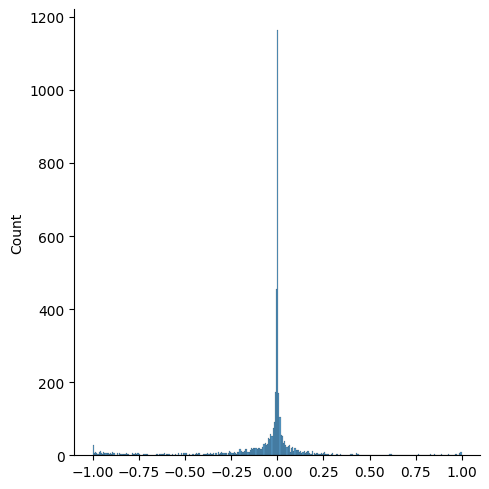

In [52]:
import seaborn as sns
sns.displot((stats["target_tox"] - stats["pred_tox"]).sort_values());